## Humor detection challenge from Kaggle

In [1]:
!wget https://github.com/ravi-ilango/acm-dec-2020-nlp/blob/main/lab5/humor_data.zip?raw=true -O humor_data.zip
!unzip humor_data.zip

--2021-06-04 15:13:03--  https://github.com/ravi-ilango/acm-dec-2020-nlp/blob/main/lab5/humor_data.zip?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/ravi-ilango/aicamp-mar-2021/blob/main/lab5/humor_data.zip?raw=true [following]
--2021-06-04 15:13:03--  https://github.com/ravi-ilango/aicamp-mar-2021/blob/main/lab5/humor_data.zip?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ravi-ilango/aicamp-mar-2021/raw/main/lab5/humor_data.zip [following]
--2021-06-04 15:13:03--  https://github.com/ravi-ilango/aicamp-mar-2021/raw/main/lab5/humor_data.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ravi-ilango/aicamp-mar-2021/main/lab5/humor_da

In [2]:
!pip install transformers
!pip install sentencepiece
!pip install plotly

     |████████████████████████████████| 2.3MB 7.5MB/s 
     |████████████████████████████████| 901kB 35.9MB/s 
     |████████████████████████████████| 3.3MB 41.6MB/s 
     |████████████████████████████████| 1.2MB 9.7MB/s 


In [3]:
import pandas as pd

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC

import plotly.express as px
import matplotlib.pyplot as plt

### Load data


In [4]:
#
# text are stored in the variable text
# humor or not labels are stored in the variable humor
#
df = pd.read_csv('./humor_data/dataset.csv')

df = df[:40000]

text = df.text.values
labels = df['humor'].apply(lambda x: 1 if x else 0).values

print(text.shape)

(40000,)


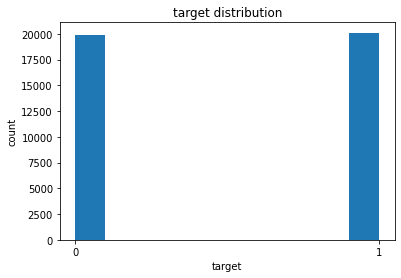

In [5]:
plt.hist(labels)
plt.xlabel('target')
plt.ylabel('count')
plt.title('target distribution')
plt.xticks(np.arange(len(np.unique(labels))));

### Fit sklearn classifier based models

In [6]:
%%time

X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['humor'], test_size=.2, stratify=df['humor'], random_state=42)

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_train)
Y = y_train

X_val = vectorizer.transform(X_test)
Y_val = y_test


CPU times: user 519 ms, sys: 21.7 ms, total: 541 ms
Wall time: 555 ms


In [7]:
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('SGD', SGDClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
#models.append(('SVM', SVC()))
models.append(('SVMLinear', LinearSVC()))

In [8]:
%%time

results = []
names = []
for name, model in models:
    print (f"Evaluating {name}")
    model.fit(X, Y)
    pred_test = model.predict(X_val)
    test_accuracy = np.mean(pred_test == Y_val)
    results.append(test_accuracy)
    names.append(name)

Evaluating LR
Evaluating SGD
Evaluating KNN
Evaluating CART
Evaluating SVMLinear
CPU times: user 14.9 s, sys: 1.54 s, total: 16.5 s
Wall time: 15.7 s


### Algorithm comparison

In [9]:
results_df = pd.DataFrame([names, results]).transpose()
results_df.columns = ["model", "accuracy"]

fig = px.scatter(results_df, "model", "accuracy", text="accuracy", size_max=100)
fig.update_traces(textposition='top center')
fig.update_layout(title_text='Model Comparison', title_x=0.5)
fig.show()

## XLNet Model

In [13]:
import torch

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import XLNetTokenizer, XLNetForSequenceClassification, AdamW

# Tokenize with XLNet tokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
padded_sequences = tokenizer(list(text), padding=True)
print (f"tokenized inputs {padded_sequences['input_ids'][0]}")


tokenized inputs [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 17, 2595, 93, 2340, 254, 1414, 78, 15765, 2340, 60, 17, 26, 3017, 117, 23, 19, 17, 150, 26, 98, 50, 926, 26, 4, 3]


In [14]:
# include <your code>

from sklearn.model_selection import train_test_split

# Use train_test_split to split our data into train and validation sets for training
input_ids = padded_sequences['input_ids']
attention_masks = padded_sequences['attention_mask']

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.4)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.4)


In [15]:
# Convert data into torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [22]:

batch_size = 64

# Create an iterator of train data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create an iterator of validation data with torch DataLoader 
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [23]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print (torch.cuda.get_device_name(0))

# include <your code>
    
# Load XLNetForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

num_labels = 2

model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=num_labels)
model.to(device)

# XLNet fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

Tesla T4


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [24]:
import os 
model_path = './xlnet_humor_detection_state_dict.pth'

if os.path.exists(model_path):
    print ("Loading weights from saved model...")
    model.load_state_dict(torch.load(model_path, map_location=device))

## Train and Eval functions

In [25]:
def train(model, iterator, optimizer):

    model.train()  

    epoch_loss = 0

    for step, batch in enumerate(iterator):
        
        #retrieve input data
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        #resets the gradients after every batch
        optimizer.zero_grad()

        # Forward pass
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = output['loss']
        
        # Backward pass
        loss.backward()
        
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        
        # loss
        epoch_loss += loss.item()

        if step%50==0:
            print (f"step: {step}")

    
    return epoch_loss / len(iterator)

In [26]:
# include <your code>

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Evaluate
def evaluate(model, iterator):
    
    #initialize every epoch
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    for batch in iterator:
        
        #retrieve input data
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        #deactivates autograd
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = output['logits']

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
        epoch_acc += tmp_eval_accuracy
        
    return epoch_acc / len(iterator)

## Train

In [27]:
from tqdm import trange

# include <your code>

N_EPOCHS = 1
best_valid_acc = 0

# XLNet training loop
for _ in trange(N_EPOCHS, desc="Epoch"):  

    #train the model
    train_loss = train(model, train_dataloader, optimizer)
    
    #evaluate the model
    valid_acc = evaluate(model, validation_dataloader)
    
    #save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        print ("saving model ...")
        torch.save(model.state_dict(), model_path)
    
    print(f'\t Train Loss: {train_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

step: 0
step: 50
step: 100
step: 150
step: 200
step: 250
step: 300
step: 350
saving model ...



Epoch: 100%|██████████| 1/1 [05:09<00:00, 309.73s/it]

	 Train Loss: 0.126 | Val. Acc: 96.58%


## Model Comparison

In [30]:
results_df = results_df.append({'model': 'XLNet', 'accuracy': best_valid_acc}, ignore_index=True)

fig = px.scatter(results_df, "model", "accuracy", text="accuracy", size_max=100)
fig.update_traces(textposition='top center')
fig.update_layout(title_text='Model Comparison', title_x=0.5)
fig.show()